In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras
import tensorflow as tf
import numpy as np
from numpy  import expand_dims
import cv2
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
np.random.seed(15)

Using TensorFlow backend.


# 0. Data preprocessing(데이터 전처리)

- 데이터는 네트워크에 주입되기 전에 floating 타입의 텐서로 적절하게 전처리되어 있어야 함
- 데이터가 JPEG 파일로 되어 있을 때, <ins>**네트워크에 주입**</ins>하려면 대략 다음 과정을 따름
    1. 사진 파일을 읽음
    2. JPEG 콘턴츠를 RGB 픽셀 값으로 디코딩함
    3. floating 타입의 텐서로 변환
    4. 픽셀 값(0 ~ 255)의 스케일을 [0,1]사이로 조정(**신경망은 작은 입력 값을 선호하기 때문**)


- 케라스에는 keras.preprocessing.image라는 유틸리티가 위의 과정들을 자동으로 처리해줌
- 특히 **ImageDataGenerator** 클래스는 (디스크에 있는 이미지 파일)-->(전처리된 배치 텐서)로 자동으로 바꾸어 주는 파이썬 generator를 만들어 줌

-----

### <font color='red'>keras.preprocessing.image.ImageDataGenerator</font>(<ins>rotation_range</ins>=0, <ins>width_shift_range</ins>=0.0, <ins>height_shift_range</ins>=0.0, <ins>brightness_range</ins>=None, <ins>shear_range</ins>=0.0, <ins>zoom_range</ins>=0.0, <ins>channel_shift_range</ins>=0.0, <ins>fill_mode</ins>='nearest', <ins>horizontal_flip</ins>=False, <ins>vertical_flip</ins>=False, <ins>rescale</ins>=None)


Parameters:
- **rotation_range** : 랜덤하게 이미지를 회전시킬 각도(0~180사이, int)  /  ex) 50이면 회전 각도의 범위는 -50 ~ 50 이다.
- **width_shift_range** : 이미지를 수평으로 랜덤하게 평행 이동 시킬 범위(전체 너비에 대한 비율)
    - **case1) >=1** : 픽셀(pixels)로 간주
    - **case2) < 1** : 전체 너비에 대한 비율
    - **case3-1) int** : 구간 `(-width_shift_range, +width_shift_range)`에서 integer 하나를 뽑고 case1)을 반복
    - **case3-2) 1-D array of integers-like** : array에서 하나를 랜덤하게 선택하고 case3-1)을 반복
    - With `width_shift_range=2` possible values are integers `[-1, 0, +1]`, same as with `width_shift_range=[-1, 0, +1]`, while with `width_shift_range=1.0` possible values are floats in the interval [-1.0, +1.0).

- **height_shift_range** : 이미지를 수직으로 랜덤하게 평행 이동 시킬 범위(전체 높이에 대한 비율)
    - **case1) >=1** : 픽셀(pixels)로 간주
    - **case2) < 1** : 전체 높이에 대한 비율
    - **case3-1) int** : 구간 `(-height_shift_range, +height_shift_range)`에서 integer 하나를 뽑고 case1)을 반복
    - **case3-2) 1-D array of integers-like** : array에서 하나를 랜덤하게 선택하고 case3-1)을 반복
    - With `height_shift_range=2` possible values are integers `[-1, 0, +1]`, same as with `height_shift_range=[-1, 0, +1]`, while with `height_shift_range=1.0` possible values are floats in the interval [-1.0, +1.0).
    
- **brightness_range** : Tuple or list of two floats. Range for picking a brightness shift value from.
- **shear_range** : Float. Shear angle in counter-clockwise direction in degrees
- **zoom_range** : <ins>Float</ins> or <ins>[lower, upper]</ins>.
    - **float** : Range for random zoom is `[1-zoom_range, 1+zoom_range]`
    - **[lower, upper]** : Range for random zoom
- **channel_shift_range** : Float. Range for random channel shifts.
- **fill_mode** : One of {<ins>"constant"</ins>(default), "nearest", "reflect" or "wrap"}. 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략 :
    - **'constant'** : kkkkkkkk|abcd|kkkkkkkk (cval=k)
    - **'nearest'** : aaaaaaaa|abcd|dddddddd
    - **'reflect'** : abcddcba|abcd|dcbaabcd
    - **'wrap'** : abcdabcd|abcd|abcdabcd
- **horizontal_flip** : Boolean. Randomly flip inputs horizontally.
- **vertical_flip** : Boolean. Randomly flip inputs vertically.
- **rescale** : rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).


### Ref : https://keras.io/preprocessing/image/

# 1. Data Augmentation(데이터 증식)

- over-fitting은 학습할 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생
- **data augmentation**은 <ins>기존 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법</ins>
- 하지만 정확히 말하자면, **original 데이터를 받아들여서 랜덤하게 변환시켜서 변환된 새로운 데이터들만 리턴하는 것!**<br>
(https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)
- 그럴듯한 이미지를 생성하도록 여러 가지 랜덤한 변환을 적용하여 샘플을 늘림
- <font style="background-color:yellow">훈련할 때 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표</font>
- 모델이 데이터의 여러 측면을 학습하면 일반화에 도움이 됌


<img src=augmentation1.png width=800>


이미지 출처 : 
https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/

<img src=keras_data_augmentation_generated_dataset.jpg width=500 height=400>

이미지 출처 : https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

keras에서는 ImageDataGenerator를 통해 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있음

- Translations
- Rotations
- Changes in scale
- Shearing
- Horizontal (and in some cases, vertical) flips


### Type 1: Dataset generation and data expansion via data augmentation (less common)
>실제로 물리적인 훈련데이터를 더 늘리는 방법

<img src=keras_data_augmentation_dataset_generation.png width=300>

출처 : https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

### Type 2: In-place/on-the-fly data augmentation (most common)
> **ImageDataGenerator** 클래스가 수행하는 방법

- in-place 혹은 on-the-fly라고 하는 이유는 학습때만 이 증식이 이루어지기 때문이다.
- batch 수 만큼 ImageDataGenerator가 <ins>실시간으로 원본 제외하고 랜덤하게 변환한 데이터 셋을 리턴함</ins>
<img src=keras_data_augmentation_in_place.png width=300 height=500 class="center">

출처 : https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

### 다음과 같이 Type2를 오해하면 안됌
<img src=keras_data_augmentation_incorrect.png  width=300>

출처 : https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [2]:
img = tf.keras.preprocessing.image.load_img('cat.jpg')  # 이미지 객체임
print(img)
data = tf.keras.preprocessing.image.img_to_array(img)   # data 만 추출
print(data.shape)
sample = expand_dims(data,0)
print("shape of sample : ", sample.shape)
sample2 = expand_dims(data,2)
print("shape of sample2 : ", sample2.shape)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x2664D6A0488>
(720, 1280, 3)
shape of sample :  (1, 720, 1280, 3)
shape of sample2 :  (720, 1280, 1, 3)


In [3]:
# opencv 사용해 이미지 loaidng하는 또다른 방법

# data = cv2.imread('cat.jpg')
# data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) # opencv 채널로 읽어들일 때는 반드시 RGB로 변환시켜줘야 함!
# sample = expand_dims(data,0)
# print(sample.shape)

---

## ImageDataGenerator 메서드

### 1. <font color=red>flow</font>(x, y=None, batch_size=32,  save_to_dir=None, save_prefix='', save_format='png', subset=None)
>데이터와 라벨 배열을 받아 증강된 데이터의 배치를 생성합니다.

Parameters:

- **x** : input 데이터. 계수 4의 numpy 배열 혹은 튜플. 튜플인 경우 첫 번째 성분이 이미지를 담고 두 번때 성분이 어떤 수정도 없이 아웃풋에 전달되는 또 다른 numpy 배열 혹은 numpy 배열의 리스트를 담습니다. 이미지와 함께 다양한 종류의 데이터를 모델에 전달할 때 사용할 수 있습니다. 흑백 데이터의 경우 이미지 배열의 채널 축의 값이 1이어야 하며, RGB 데이터의 경우 3, RGBA 데이터의 경우 4의 값을 가져야 합니다.
- **y** : 라벨
- **batch_size** : 정수 (디폴트 값: 32)
- **save_to_dir** : None 혹은 문자열 (디폴트 값: None). 이는 디렉토리를 선택적으로 지정해서 생성된 증강 사진을 저장할 수 있도록 합니다. (현재 작업을 시각화하는데 유용합니다)
- **save_prefix** : 문자열 (기본값: ''). 저장된 사진의 파일이름에 사용할 접두부호 (save_to_dir이 지정된 경우에만 유의미합니다).
- **save_format** : "png"나 "jpeg" 중 하나 (save_to_dir이 지정된 경우에만 유의미합니다). 디폴트 값: "png".

출처 : https://keras.io/ko/preprocessing/image/

In [4]:
# 어떤 기하학적인 변형을 쓸 것인지 설정
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range = 0.7)


# 위에서 cat.jpg를 이용해 정의한 sample이라는 파일 하나만 통과시켰기 때문에
# flow의 batch_size는 1을 하든 2를 하든 아래 셀에서처럼 결과는 한 개의 이미지만 나온다.
obj = generator.flow(sample, batch_size=1)

(1, 720, 1280, 3)
float32


(720, 1280, 3)


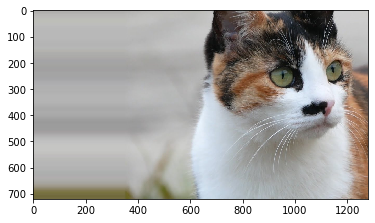

In [7]:
# run 할 때마다 다른 이미지 나온다.
image = obj.next()   # obj.next()함수를 한 번 호출할 때 마다 obj는 설정된 경로에서 batch_size에 맞춰
                     # 이미지를 랜덤하게 수평으로 평행이동하여 labelling하여 불러옵니다.
    
print(image.shape)
print(image.dtype) # obj 함수로 리턴되는 객체는 float타입의 객체
print('\n')


print(image[0].shape)
# plt.imshow(image[0].astype('uint8') )  #  plt로 할때는 0~1사이로  혹은 타입을 uint8로

plt.imshow(image[0]/255)  #  plt로 할때는 0~1사이로  혹은 타입을 uint8로
plt.show()

In [8]:
# 윗 셀의 코드를 rescale 옵션을 이용하면 더 간편하게 만들 수 있음

generator = tf.keras.preprocessing.image.ImageDataGenerator(    
    width_shift_range = 0.7, rescale=1./255)   # rescale 해주면 정규화하고, imshow할때 type 변환 필유없다.
obj = generator.flow(sample, batch_size=1)   

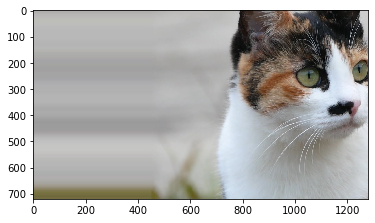

In [9]:
image = obj.next()
plt.imshow(image[0] )

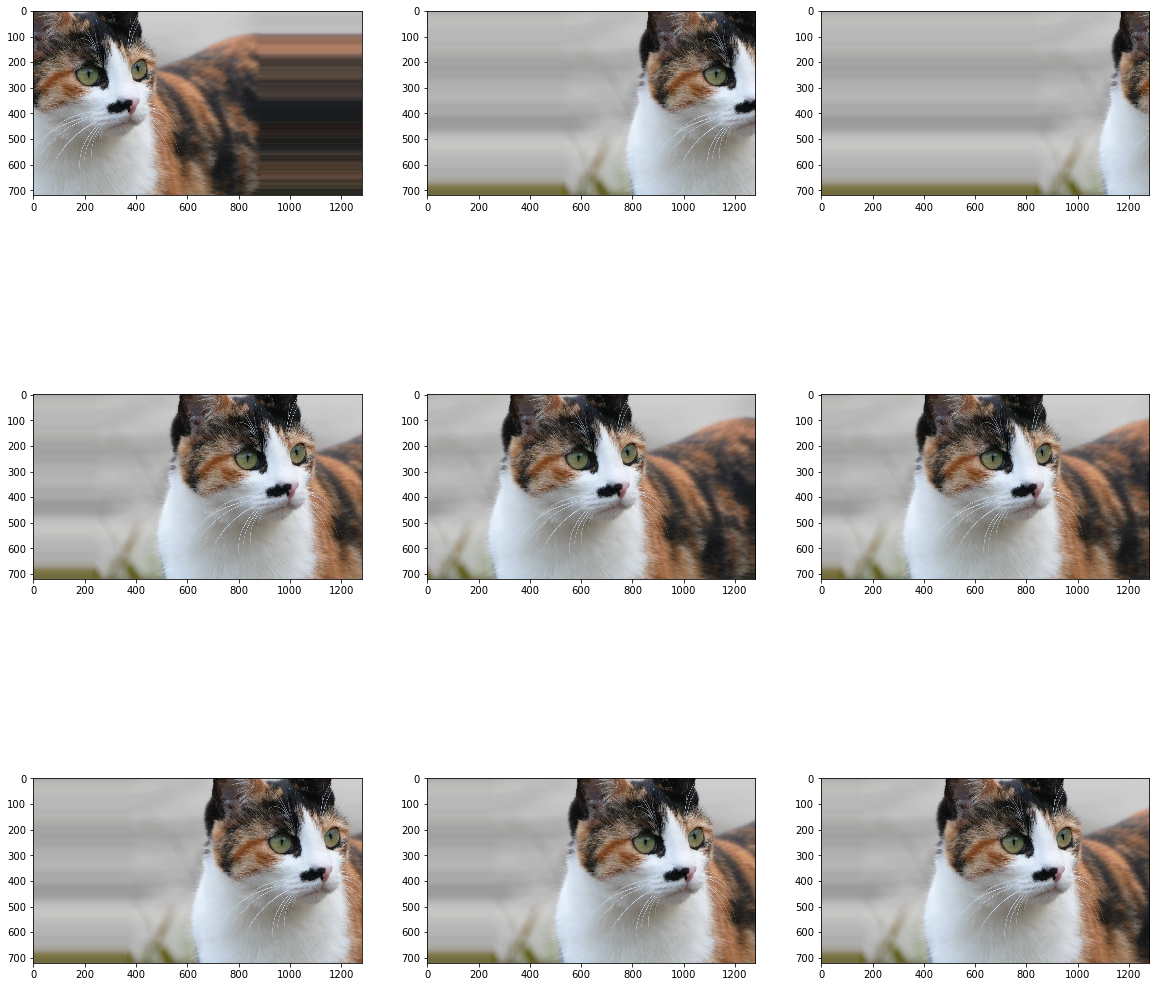

In [10]:
fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])  

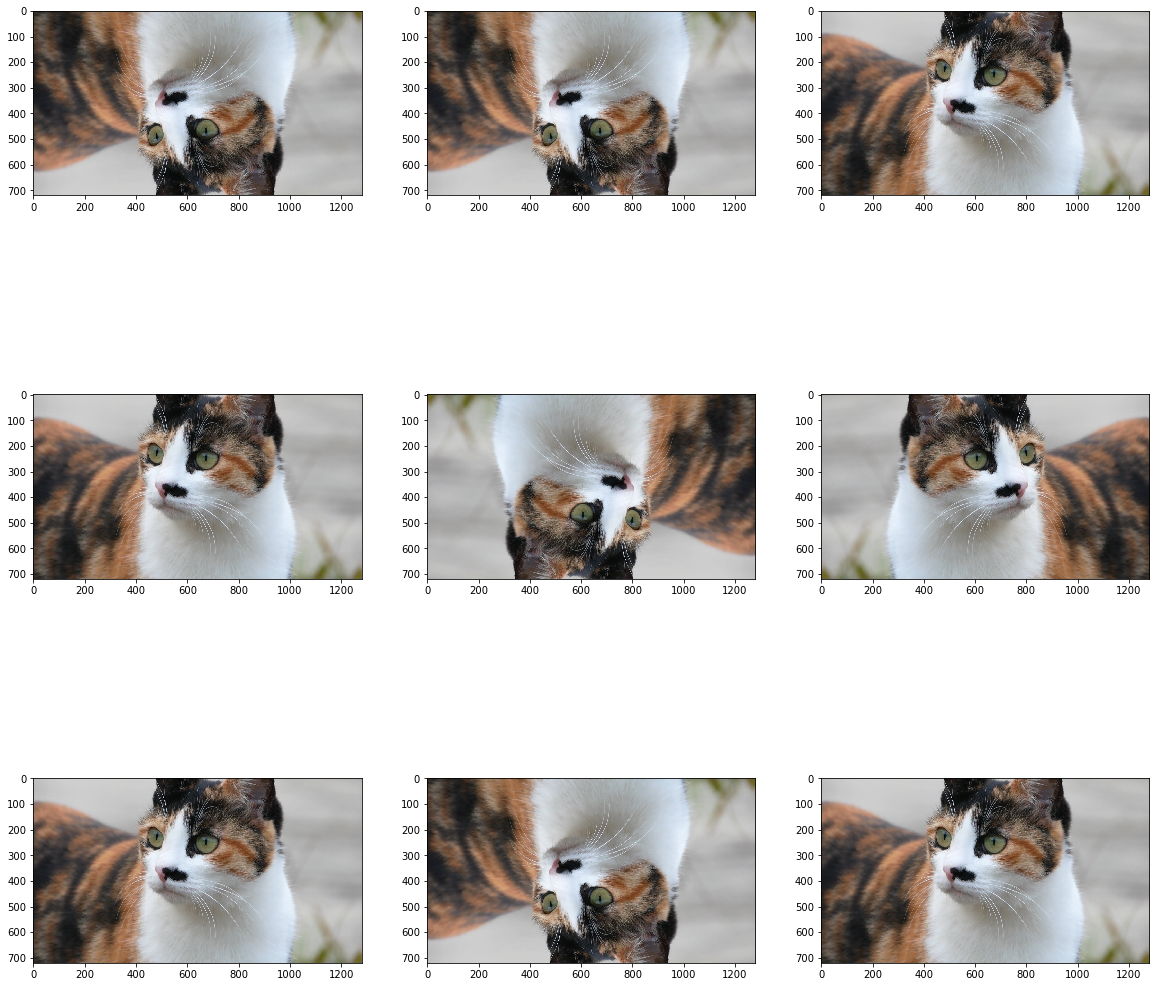

In [12]:
# flip(반전)이 들어간 코드
generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    horizontal_flip = True, vertical_flip = True,
    rescale=1./255)
obj = generator.flow(sample, batch_size=1)   

fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])   

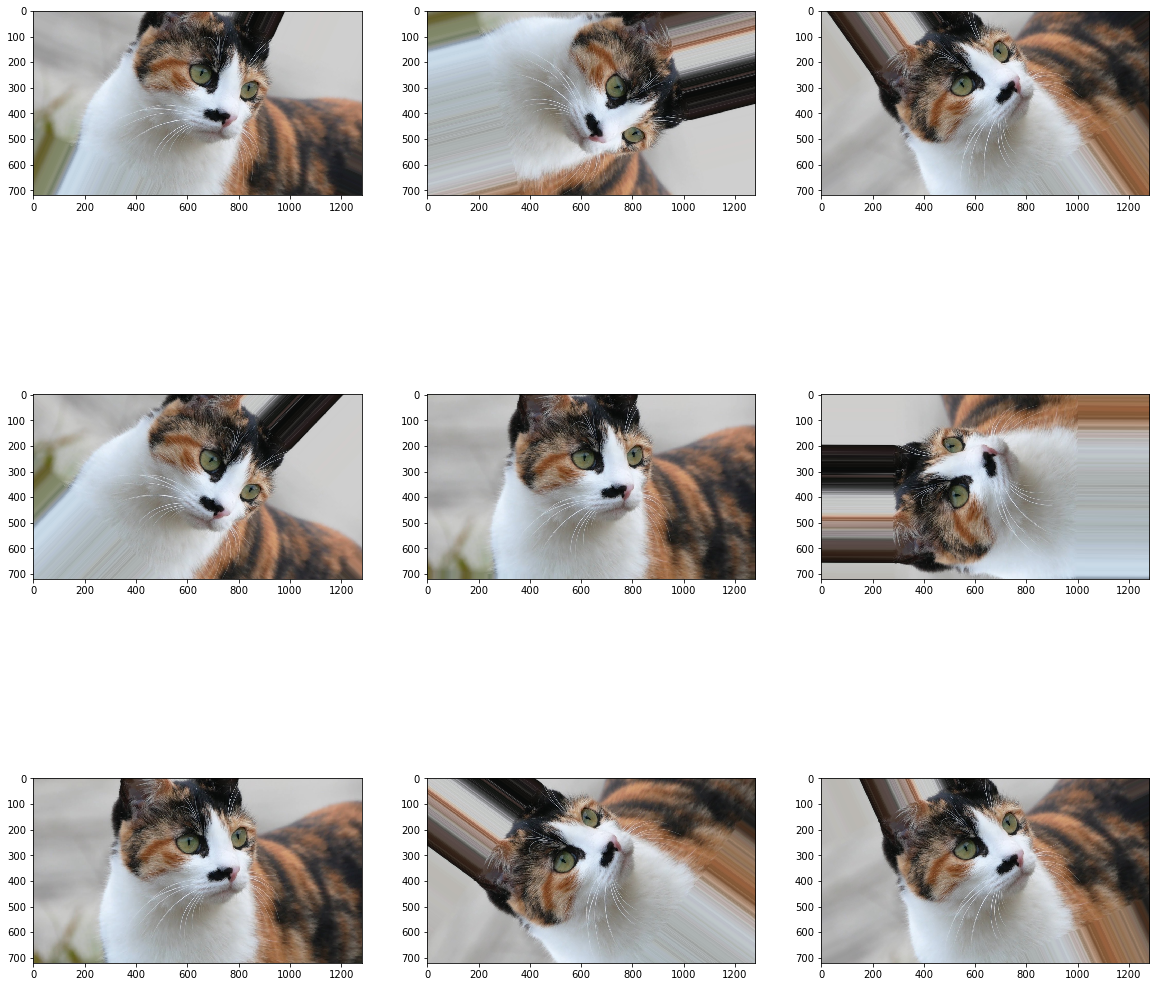

In [13]:
# rotation과 rescale이 들어간 코드
generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    rotation_range=90,
    rescale=1./255)
obj = generator.flow(sample, batch_size=1)   

fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])   
    

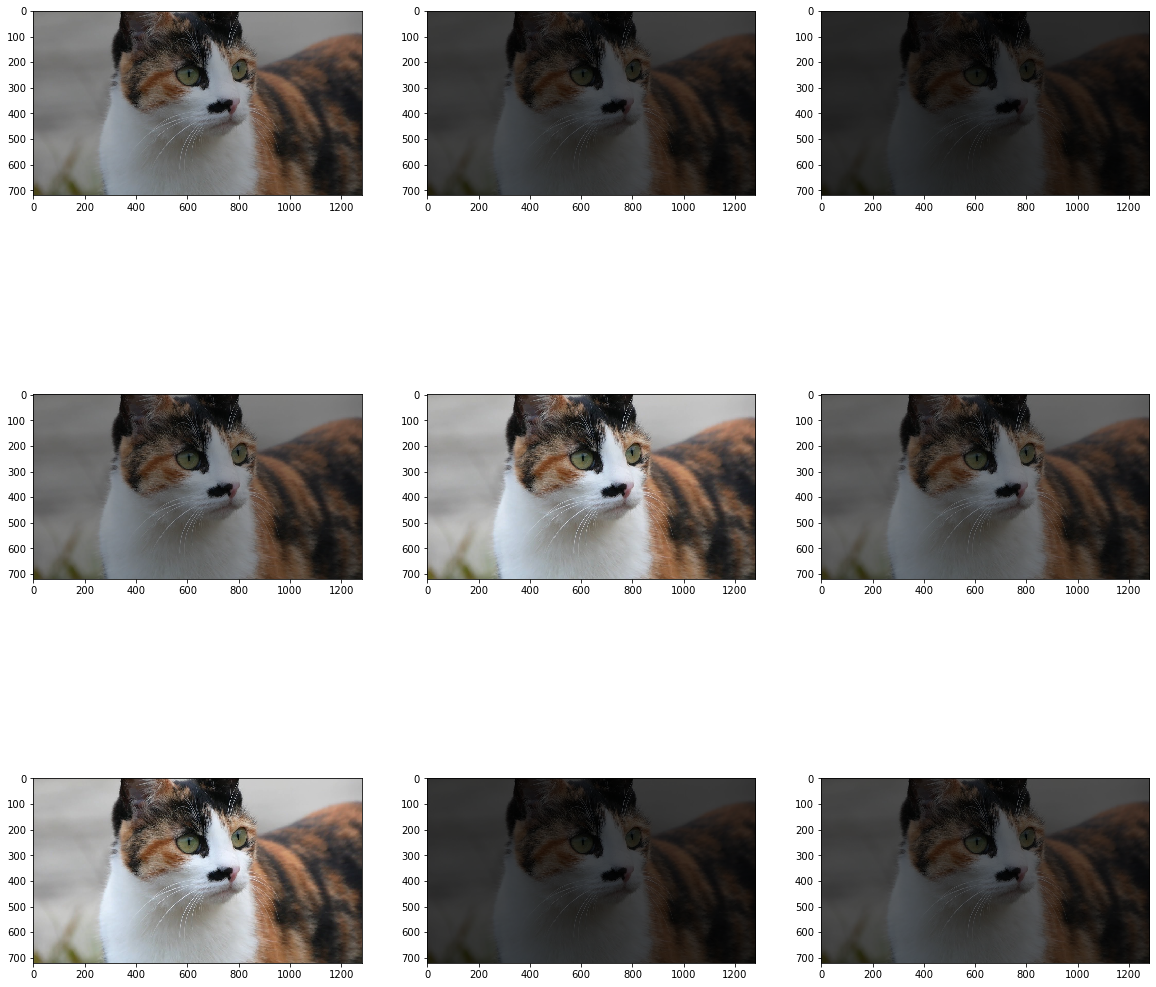

In [14]:
# 밝기와 rescale이 들어간 코드
generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    brightness_range=[0.2, 1.0],       
    rescale=1./255)
obj = generator.flow(sample, batch_size=1)   

fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])   

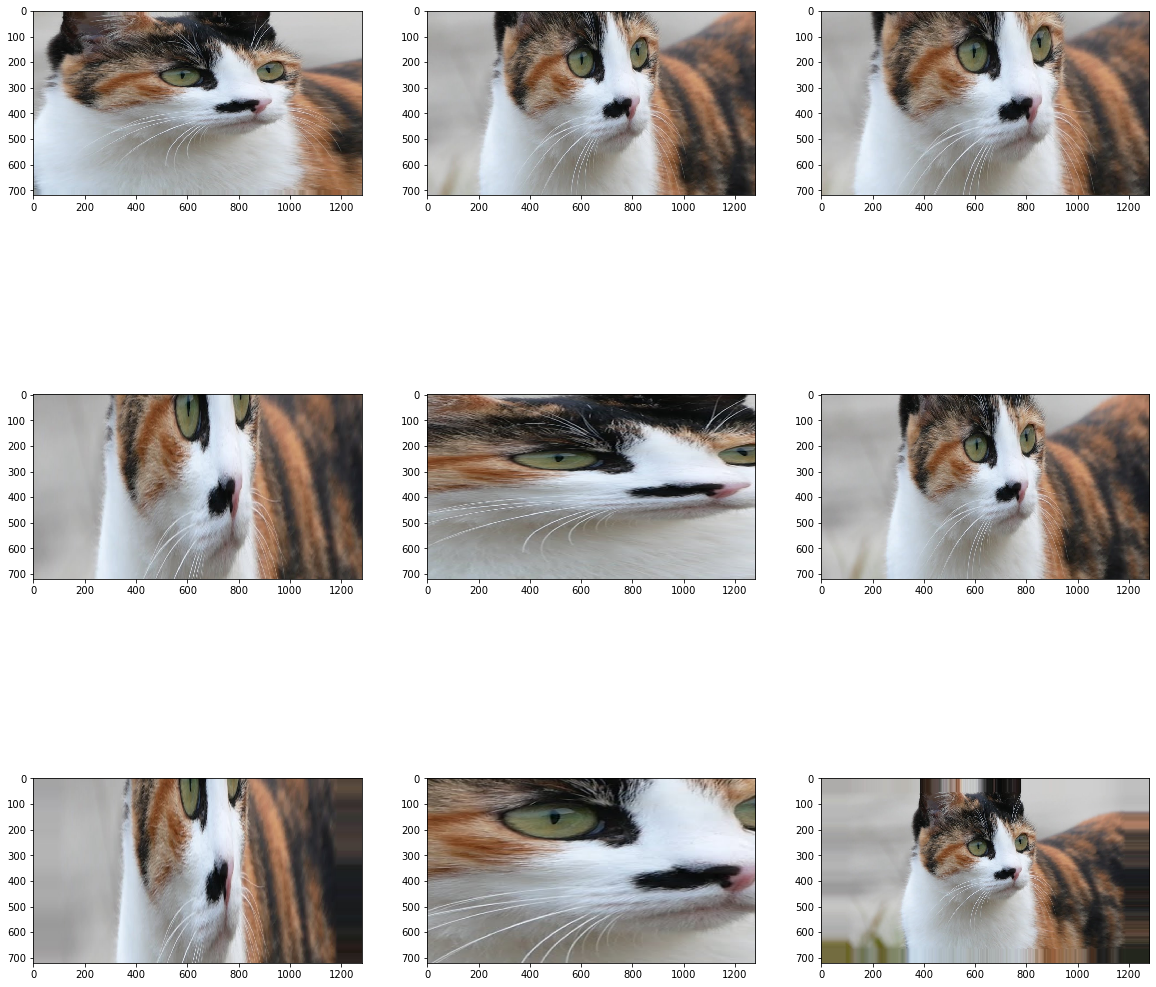

In [15]:
# zoom_range와 rescale이 들어간 코드
generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    zoom_range=[0.2, 1.2],   
    rescale=1./255)
obj = generator.flow(sample, batch_size=1)   

fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])   

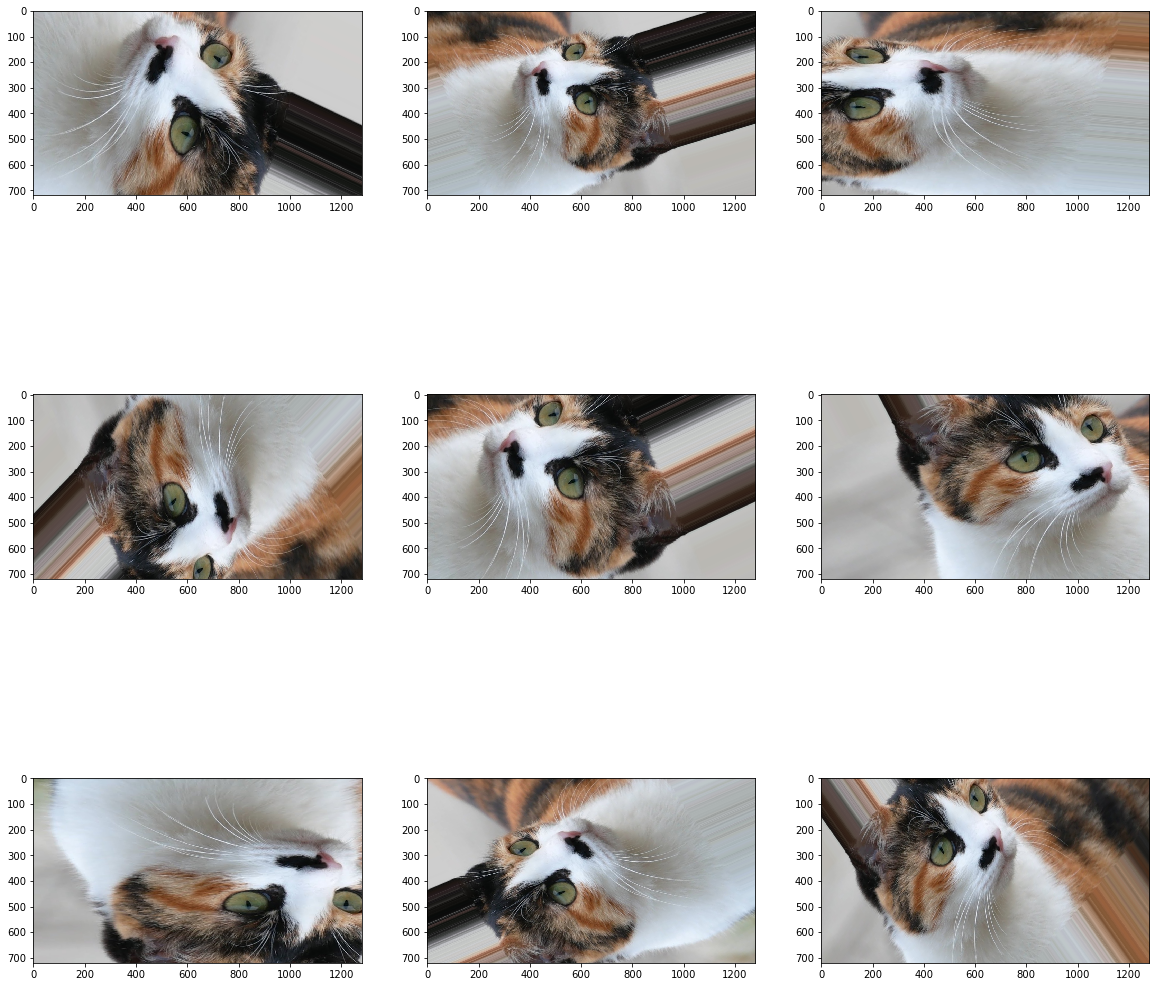

In [16]:
# 한꺼번에 적용하기
generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    width_shift_range = 0.2,
    zoom_range=[0.5, 1.0],   
    horizontal_flip = True, vertical_flip = True,
    rotation_range=90,
    rescale=1./255)
obj = generator.flow(sample, batch_size=1)   

fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])   

In [17]:
# 파일로 저장하기
obj = generator.flow(sample, batch_size=1, save_to_dir='tmp',  # tmp폴더는 생성되어 있어야 함
    save_prefix="image", save_format="jpg")    

for i in range(0, 5):
    obj.next()    

### 2. <font color=red>flow_from_directory</font>(directory, target_size=(256, 256), class_mode='categorical', batch_size=32, save_to_dir=None, save_prefix='', save_format='png')
>디렉토리에의 경로를 전달받아 증강된 데이터의 배치를 생성합니다.

#### Parameters :

- **directory** : 표적 디렉토리에의 경로. 반드시 한 클래스 당 하나의 하위 디렉토리가 있어야 합니다. 각 하위 디렉토리 내에 위치한 어떤 PNG, JPG, BMP, PPM 혹은 TIF 이미지도 생성자에 포함됩니다.
- **target_size** : 정수 튜플 (높이, 넓이) 모든 이미지의 크기를 재조정할 치수. 생략시 디폴트 (256,256)
- **class_mode** : "categorical", "binary", "sparse", "input", 혹은 None 중 하나. 디폴트 값: "categorical". 반환될 라벨 배열의 종류를 결정합니다:
    - **"categorical"**은 2D형태의 원-핫 인코딩된 라벨입니다,
    - **"binary"**는 1D 형태의 이진 라벨입니다, "sparse"는 1D 형태의 정수 라벨입니다,
    - **"input"**은 인풋 이미지와 동일한 이미지입니다 (주로 자동 인코더와 함께 사용합니다).
    - **None**의 경우, 어떤 라벨되 반환되지 않습니다 (생성자가 이미지 데이터의 배치만 만들기 때문에, model.predict_generator(), model.evaluate_generator() 등과 함께 사용하는 것이 유용합니다). class_mode가 None일 경우, 제대로 작동하려면 데이터가 directory 내 하위 디렉토리에 위치해야 한다는 점을 유의하십시오.
- **batch_size** : 데이터 배치의 크기 (디폴트 값: 32).
- **save_to_dir** : None 혹은 문자열 (디폴트 값: None). 이는 디렉토리를 선택적으로 지정해서 생성된 증강 사진을 저장할 수 있도록 해줍니다 (현재 작업을 시각화하는데 유용합니다).
- **save_prefix** : 문자열. 저장된 사진의 파일 이름에 사용할 접두부호 (save_to_dir이 설정된 경우에만 유의미합니다).
- **save_format** : "png"와 "jpeg" 중 하나 (save_to_dir이 설정된 경우에만 유의미합니다). 디폴트 값: "png".

#### 반환값
>`(x, y)` 튜플을 만들어내는 `DirectoryIterator`. 

- x는 (배치 크기, target_size, 채널)의 형태의 이미지 배치로 구성된 numpy 배열
- y는 그에 대응하는 라벨로 이루어진 numpy 배열입니다.(배열 그 자체는 큰 쓸모X)

**출처** : https://keras.io/ko/preprocessing/image/

-----
**참고** : 
아래의 셀들을 실행시키며 공부할 때 https://ballentain.tistory.com/4 가 많은 도움이 됐음

In [33]:
# 2.  디렉토리로 부터 augmentation
# 실행결과는 hard_handwriting_shape 디렉토리에 3개의 하위 디렉토리가 있고 다시 그 안에 총 75개의 이미지가 있다는 뜻

obj = generator.flow_from_directory(
    'hard_handwriting_shape',
    target_size = (150, 150),
    batch_size = 4,
    class_mode = 'binary' ) # binary(label) --> 벡터
                            # categorical(one-hot) --> 행렬
                            # (한 번 체크해보는 것도 괜찮음)

Found 75 images belonging to 3 classes.


In [37]:
# generator는 이 배치를 무한정 만들어내기 때문에 반복 루프 안 어디에선가 break문을 사용해야 함
# 이 부분을 이해할 때 https://ballentain.tistory.com/4에서 두번째 코드가 도움 많이 됐음

iterations = 3

for i, (img, label) in enumerate(obj):
    n_img = len(label)    # batch_size의 갯수
    print(n_img)
    print(label)        # 큰 의미 없음
#     plt.imshow(img[0])
#     plt.show()
    print(img.shape)
    print('\n')
    if i is iterations - 1:
        break
# 결과를 보면 lable은 1,1,1,0 처럼 꼭 c1과 c2에서 규일하게 생성되는것은 아니다.

4
[2. 0. 2. 2.]
(4, 150, 150, 3)


4
[0. 2. 2. 1.]
(4, 150, 150, 3)


4
[0. 2. 2. 0.]
(4, 150, 150, 3)




Found 75 images belonging to 3 classes.
[0. 2. 1. 2.]


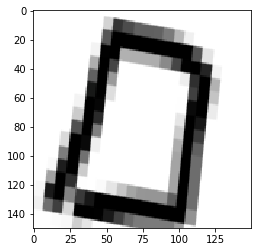

[0. 0. 2. 2.]


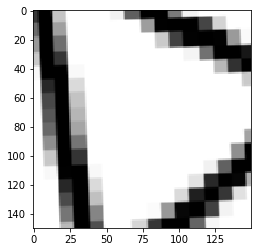

In [42]:
# 저장하기(이 셀을 계속해서 run하면 계속해서 이미지파일이 생성됌)
obj = generator.flow_from_directory(
    'hard_handwriting_shape',
    target_size = (150, 150),  
    batch_size = 4,   # 8개 이미지(iterations까지 고려해서) 중에서 최대4개 만들어냄
    class_mode = 'binary',
    save_prefix="image", save_format="jpg",save_to_dir='tmp')

iterations = 2

for i, (img, label) in enumerate(obj):
    n_img = len(label)    # batch_size의 갯수
    print(label)
    plt.imshow(img[0])
    plt.show()
#     print(img.shape)
    if i is iterations - 1:
        break
# tmp 폴더하나에 (iterations) X (batch_size) = 8개 이미지 출력됙다.  batch별로 저정할수 없나?( 좀더 찾아바야함)

----

#  2. 도형 

In [74]:
np.random.seed(5)


# 데이터셋 불러오기 
data_aug_gen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=15,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.5,
                                  zoom_range=[0.8, 2.0],
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
                                   
img = load_img('hard_handwriting_shape/train/triangle/triangle001.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape) # 이전에 expand 방법과 같은 방법
i = 0

# 이 for는 무한으로 반복되기 때문에 우리가 원하는 반복횟수를 지정하여, 지정된 반복횟수가 되면 빠져나오도록 해야합니다.
for batch in data_aug_gen.flow(x, batch_size=1, save_to_dir='hard_handwriting_shape', save_prefix='tri', save_format='png'):
    i += 1
    if i > 30: 
        break
        

In [76]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'hard_handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'hard_handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical', shuffle=False) # shuffle : 자기 마음대로 섞는다.

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [77]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [79]:
# 모델 학습시키기
# 기존과 다른 점은 fit이 아니라 fit_generator를 써서 학습을 미리 해놓지 않고 실시간으로 함
model.fit_generator(
        train_generator,
        steps_per_epoch=15 * 100,
        epochs=10, #200
        validation_data=test_generator,
        validation_steps=5)

Epoch 1/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.0229 - accuracy: 0.9916 - val_loss: 1.4715e-04 - val_accuracy: 0.8000
Epoch 2/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.0251 - accuracy: 0.9918 - val_loss: 0.0000e+00 - val_accuracy: 0.8000
Epoch 3/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0027 - val_accuracy: 0.8000
Epoch 4/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.0102 - accuracy: 0.9969 - val_loss: 8.7420e-07 - val_accuracy: 0.8000
Epoch 5/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0244 - accuracy: 0.9927 - val_loss: 4.3826e-05 - val_accuracy: 0.8000
Epoch 6/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 1.1912e-04 - val_accuracy: 0.7333
Epoch 7/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0185 - accuracy: 0.9940 

In [89]:
# 모델 예측하기
print("-- Predict --")
output = model.predict_generator( test_generator,  steps = 5)    # batch 사이즈가 3 , 15개가 생성됨
print(output)
print('\n')

T = test_generator.classes # True값
print(T)
p = np.argmax(output, axis=1) # 예측 값
print(p)

print("인식률 = ", sum((T == p)*1) / len(T))

-- Predict --
[[9.9998605e-01 1.3931196e-05 7.4242946e-16]
 [7.8567075e-10 6.5229786e-09 1.0000000e+00]
 [9.9999976e-01 3.6995006e-13 1.9099784e-07]
 [1.0000000e+00 5.0028562e-21 3.6535558e-21]
 [1.0000000e+00 3.5203839e-18 4.5684342e-08]
 [2.6570864e-11 1.0000000e+00 2.2455581e-19]
 [1.4942118e-17 7.2627233e-09 1.0000000e+00]
 [1.0662898e-08 9.9272835e-01 7.2716498e-03]
 [8.5390154e-15 1.0000000e+00 1.7309715e-12]
 [9.9999952e-01 5.1870825e-07 1.4985589e-12]
 [1.1513281e-35 1.9714873e-28 1.0000000e+00]
 [1.9212607e-21 4.8861475e-20 1.0000000e+00]
 [1.4690416e-13 2.4465615e-08 1.0000000e+00]
 [9.6065145e-34 2.4420423e-28 1.0000000e+00]
 [3.9383180e-31 5.6696985e-34 1.0000000e+00]]


[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
[0 2 0 0 0 1 2 1 1 0 2 2 2 2 2]
인식률 =  0.8


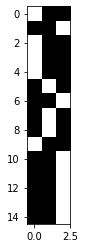

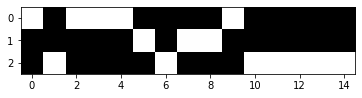

In [93]:
plt.imshow(output, cmap='gray')
plt.show()
plt.imshow(output.T, cmap = 'gray') # transpose
plt.show()
# img = output * 255



In [86]:
# 모델 평가하기
scores = model.evaluate_generator( test_generator, steps = 5)
print(scores)
print("the valid_accuracy = ", scores[1])

[0.0, 0.800000011920929]
the valid_accuracy =  0.800000011920929


In [94]:
labels = ['C', 'R', 'T']

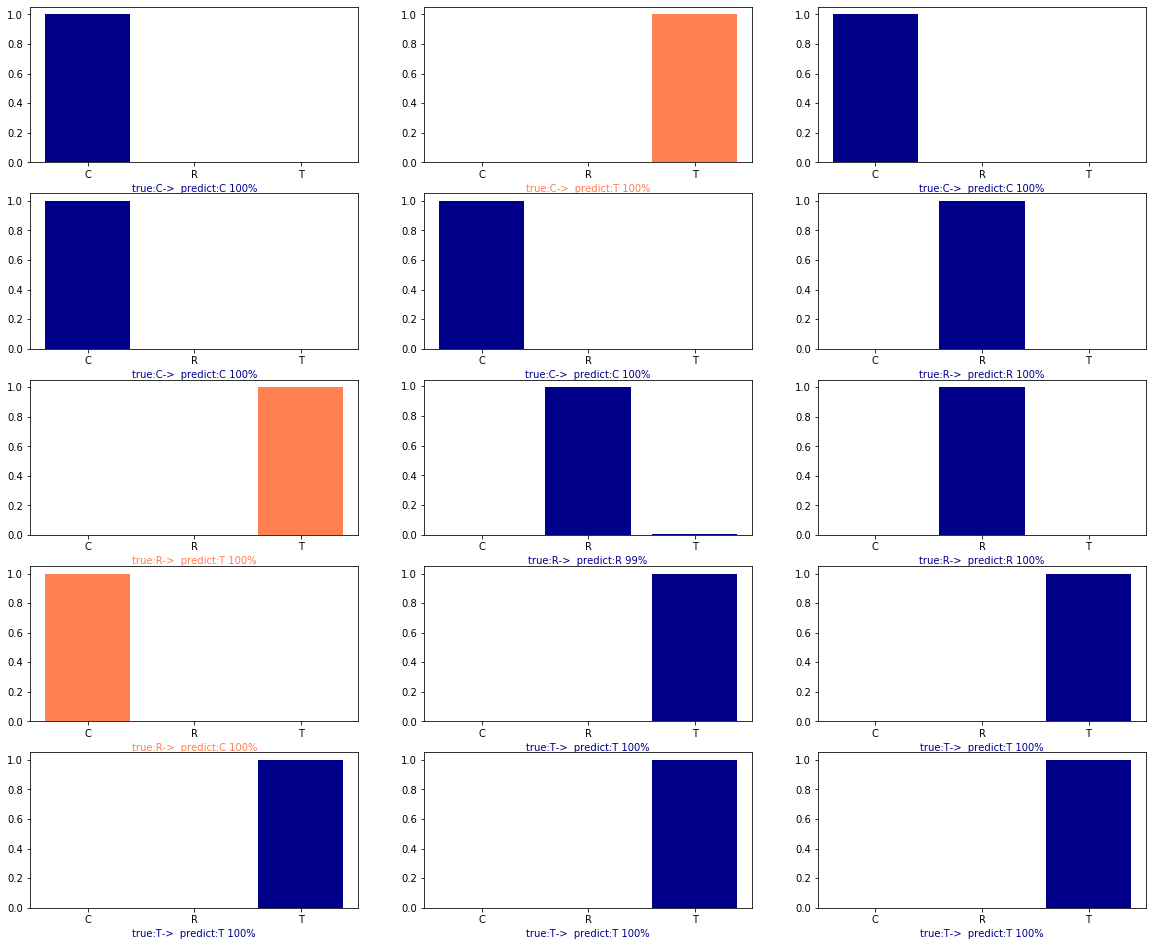

In [112]:
idx = [ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
# idx = [2,5,6,7]

plt.figure(figsize=(20, 20))

cc = 3
rr = int(len(idx) / cc)+1

for k in range( len(idx) ) :        
  i = idx[k]             
  c =  "darkblue" if  p[i] == T[i]   else "coral"    
  plt.subplot( rr ,cc, k+1)
  plt.bar(labels, output[i], color=c)
  plt.xlabel("true:{}->  predict:{} {:2.0f}%".format(labels[int(T[  i ])], 
                                                     labels[p[  i ]], 
                                                     100*np.max(output[i], axis=0)),  
             color = c )

In [145]:
test_generator = test_datagen.flow_from_directory("hard_handwriting_shape/test",
                                                 target_size = (24,24),
                                                 batch_size=15,
                                                 class_mode='binary', shuffle=False)
a = test_generator.next()
X, T = a
print(a[0].shape)
print(a[1].shape)
# 위에서는 T = test_generator.classes 라고 정의했는데 사실 같은 것임

output = model.predict(X)
p = np.argmax(output, axis=1)

Found 15 images belonging to 3 classes.
(15, 24, 24, 3)
(15,)


index =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


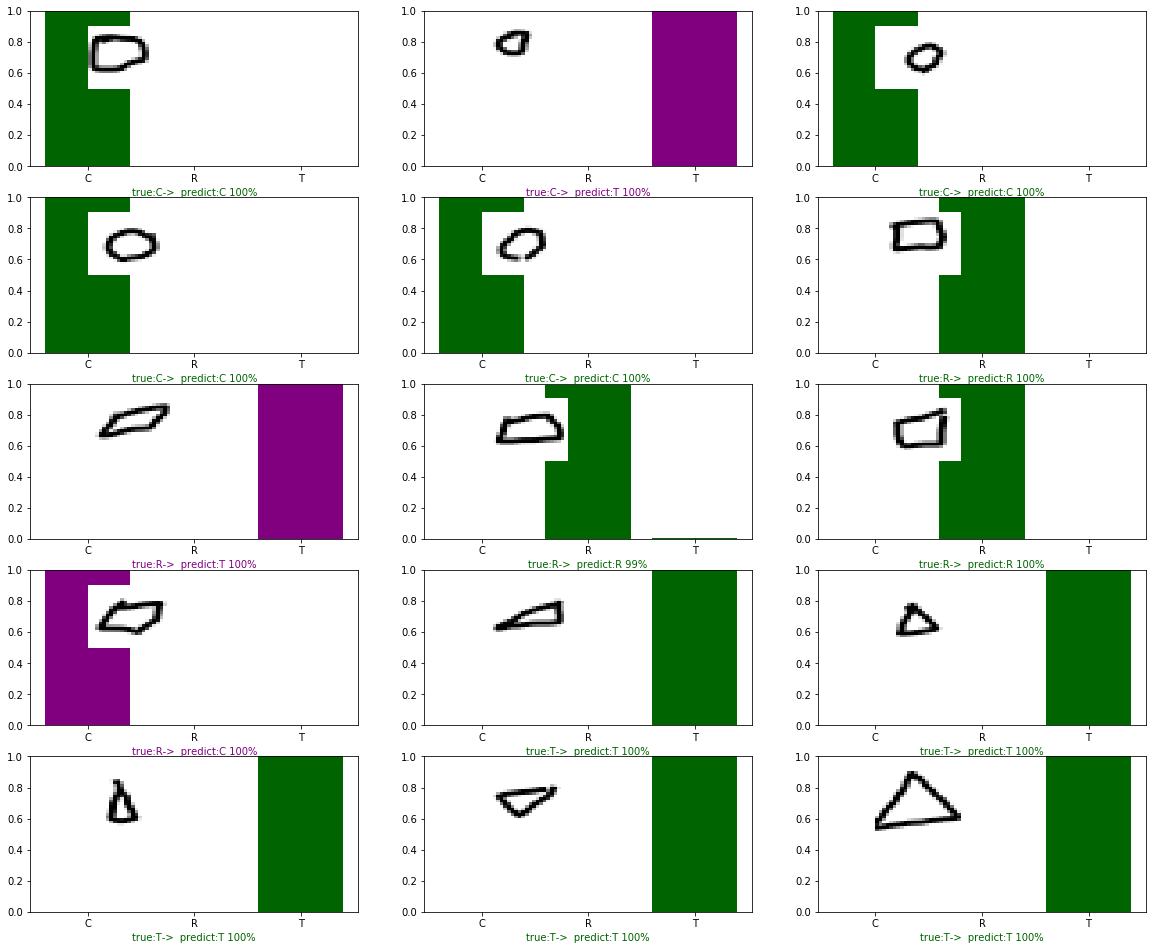

In [146]:
# 15개 모두 비교

# idx = np.where(  p != T )
idx = [ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
print("index = ", idx)

plt.figure(figsize=(20, 20))

cc = 3
rr = int(len(idx) / cc)+1

for k in range( len(idx) ) :        
  i = idx[k]             
  c =  "darkgreen" if  p[i] == T[i]   else "purple"    
  plt.subplot( rr ,cc, k+1)
  #  left and right limits, and the bottom and top limits. 
  plt.imshow(a[0][i, :,:, 0], extent=[0, 0.8, 0.5, 0.9], aspect='auto', zorder=10, cmap="gray")
  plt.ylim(0.0, 1.0)  
  plt.bar(labels, output[i], color=c)
  plt.xlabel("true:{}->  predict:{} {:2.0f}%".format(labels[int(T[  i ])], 
                                                     labels[p[  i ]],  
                                                     100*np.max(output[i], 
                                                                axis=0)),  
             color = c )
    
# plt.savefig('fig1.png')

index =  (array([1, 6, 9], dtype=int64),)


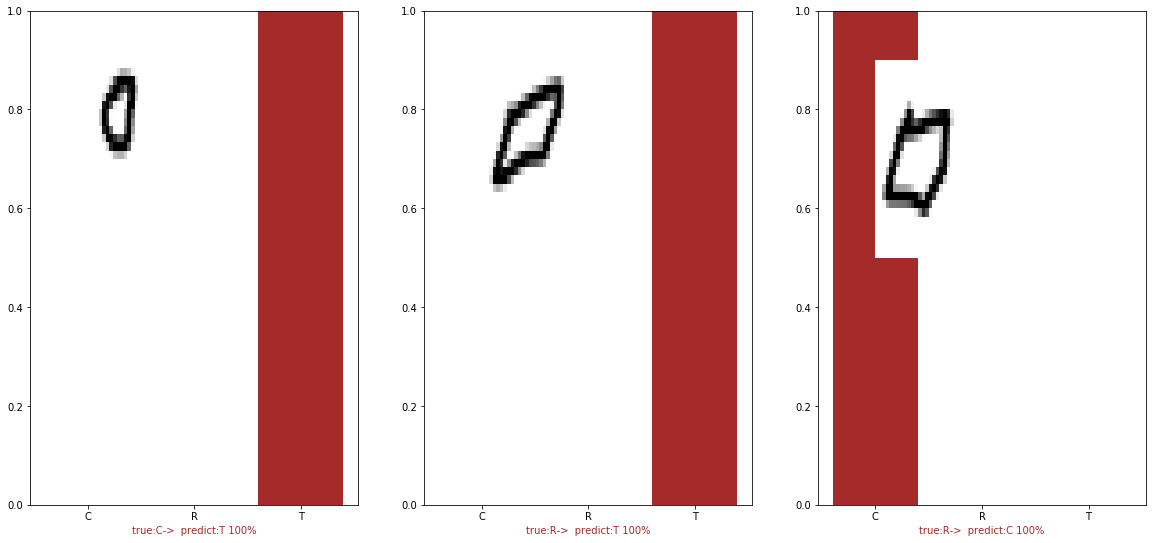

In [149]:
# True값과 Prediction값이 다른 곳에서만 비교


idx = np.where(  p != T )
print("index = ", idx)

plt.figure(figsize=(20, 20))

cc = 3
rr = int(len(idx[0]) / cc)+1

for k in range( len(idx[0]) ) :        
  i = idx[0][k]             
  c =  "blue" if  p[i] == T[i]   else "brown"    
  plt.subplot( rr ,cc, k+1)
  #  left and right limits, and the bottom and top limits. 
  plt.imshow(a[0][i, :,:, 0], extent=[0, 0.8, 0.5, 0.9], aspect='auto', zorder=10, cmap="gray")
  plt.ylim(0.0, 1.0)  
  plt.bar(labels, output[i], color=c)
  plt.xlabel("true:{}->  predict:{} {:2.0f}%".format(labels[int(T[  i ])], 
                                                     labels[p[  i ]],  
                                                     100*np.max(output[i], 
                                                                axis=0)),  
             color = c )
    
# plt.savefig('fig1.png')

---